# Taking a closer look at our crime classifier's shortcomings

In our last project, we built a detector to identify serious assaults that were downgraded into simple assaults. In this notebook we'll see how our algorithm operates, and address any issues about what this technique might miss.

<p class="reading-options">
  <a class="btn" href="/latimes-crime-classification/inspecting-classifications">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/latimes-crime-classification/notebooks/Inspecting classifications.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/latimes-crime-classification/notebooks/Inspecting classifications.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **2008-2012.csv:** cleaned crime reports - a selection of partially scrubbed reports from between 2008-2012


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/latimes-crime-classification/data/2008-2012.csv.zip -P data
!unzip -n -d data data/2008-2012.csv.zip

## Imports and setup

First we'll set some options up to make everything display correctly. It's mostly because these assault descriptions can be quite long, and the default is to truncate text after a few words.

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

%matplotlib inline

# Repeat our analysis

First we'll repeat the majority of our processing and analysis from the first notebook, then we'll get into the critique.

## Read in our data

Our dataset is going to be a database of crime reports between 2008 and 2012. It will start off with two columns:

* `CCDESC`, what criminal code was violated
* `DO_NARRATIVE`, a short text description of what happened

We're going to use this description to see if we can separate serious cases of assault compared to non-serious cases of assault.

We won't be covering the process of vectorizing our dataset and creating our classifier in this notebook. Instead, we're going to focus on analyzing the possible shortcomings of our analysis, both conceptually and technically.

In [2]:
# Read in our dataset
df = pd.read_csv("data/2008-2012.csv")

# Only use reports classified as types of assault
df = df[df.CCDESC.str.contains("ASSAULT")].copy()

# Classify as serious or non-serious
df['serious'] = df.CCDESC.str.contains("AGGRAVATED") | df.CCDESC.str.contains("DEADLY")
df['serious'] = df['serious'].astype(int)

# Downgrade 15% from aggravated to simple assault
serious_subset = df[df.serious == 1].sample(frac=0.15)
df['downgraded'] = 0
df.loc[serious_subset.index, 'downgraded'] = 1
df.loc[serious_subset.index, 'serious'] = 0

# Examine the first few
df.head()

,CCDESC,DO_NARRATIVE,serious,downgraded
2,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-S APPRCHED V AND STATED ARE YOU GOING TO FCK ME V REPLIED NO SUSP PULL ED OUT A KNIFE AND STATED IM HERE TO HURT YOU BTCH S USED PROFANITIES,1,0
4,BATTERY - SIMPLE ASSAULT,DO-SUSP USED RIGHT FIST TO PUNCH VICT IN THE HEAD ONCE N PULL VICT HAIR FOR APPRX 15 SECONDS,0,0
9,BATTERY - SIMPLE ASSAULT,DO-S APPROACHED V IN VEH S SLAPPED AND LUNGGED AT V,0,0
11,BATTERY - SIMPLE ASSAULT,DO-V STATED THAT SUSP CONFRT HER WHEN SHE TRIED TO APPR HER HUSBAND SUSP AND V HUSBAND ARE FRNDS SUSP YELLED STAY AWAY FROM HIM AND PUSHED V,0,0
16,BATTERY - SIMPLE ASSAULT,DO-SUSPS WERE VERBALLY ABUSING VICT DURING WHICH TIME S1 STRUCK VICT THREETIMES ON THE BACK OF HIS LEFT SHOULDER,0,0


## Vectorize

In [39]:
%%time

from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

stemmer = SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer,self).build_analyzer()
        return lambda doc:(stemmer.stem(word) for word in analyzer(doc))

vectorizer = StemmedTfidfVectorizer(min_df=20, max_df=0.5)

X = vectorizer.fit_transform(df.DO_NARRATIVE)
words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
words_df.head(5)

CPU times: user 1min 5s, sys: 2.43 s, total: 1min 8s
Wall time: 1min 10s


,01,10,100,101,10x,10yr,11,112,118,11th,11yr,12,12yr,13,14,14yr,15,15yr,16,17,18,18th,18yr,19,1s,1st,1x,1yr,20,20yr,21,22,23,23rd,24,25,28th,2nd,2time,2x,2x4,2yr,30,35th,36th,38th,390,39th,3mos,3rd,...,wit2,with,witha,withclos,withhi,within,without,withv,wk,wks,wndw,wo,woke,woman,women,wood,wooden,word,work,worker,workplac,would,wouldnt,wound,wrap,wre,wrench,wrestl,wrist,write,wrong,wrote,ws,wth,wtih,wy,xboyfriend,xs,yank,yard,year,yell,yellow,yes,yo,you,younger,your,yr,yrs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.313373,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.226112,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## Classify

In [40]:
%%time

X = words_df
y = df.serious

clf = LinearSVC()
clf.fit(X, y)

CPU times: user 4.62 s, sys: 2.77 s, total: 7.39 s
Wall time: 8.66 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

# Analyzing our classifier

## What words are important?

Before we see how our classifier performs, let's take a look at which words point towards a report being either simple or aggravated assault. In this case, we're going to look at the top and bottom 20 terms.

In [41]:
import eli5

eli5.show_weights(clf, vec=vectorizer, top=(20,20), horizontal_layout=True)

Weight?,Feature
+2.685,stab
+2.358,shot
+2.238,bat
+2.100,knife
+1.958,shovel
+1.952,boil
+1.908,cutter
+1.893,machet
+1.835,gasolin
+1.833,crowbar


We can throw it into a **graph form**, too.

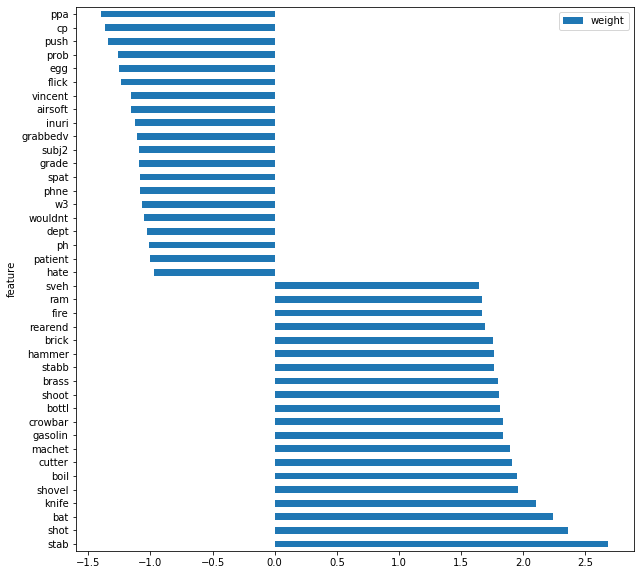

In [42]:
eli5.explain_weights_df(
    clf, 
    vec=vectorizer, top=(20,20)
).plot(
    x='feature', 
    y='weight',
    kind='barh',
    figsize=(10,10)
)

Lots of interesting stuff in there!

* Does it sound reasonable which terms imply aggravated vs simple assault?
* Which ones are misspellings? Does that worry you?
* Are there any terms in there you don't quite understand?

I personally don't understand `ppa`, so I'm going to look it up in the dataset.

In [43]:
df[df.DO_NARRATIVE.str.contains("PPA")].head()

,CCDESC,DO_NARRATIVE,serious,downgraded
286,BATTERY - SIMPLE ASSAULT,DO-S HUSBAND BECAME VERY ANGRY FOR NO APPARENT REASON AND GRABBED V RIGHT ARM AND TWISTED V ARM IN AN AWKWARD POSITION S THEN PUSHED V BODY AGAINST REFR,0,0
1506,BATTERY - SIMPLE ASSAULT,DO-V AND S INVOLVED IN ARGUMENT V AND S THEN ENGAGED IN MUTUAL COMBAT FLIGHT V AND S REFUSED PPA,0,0
1653,BATTERY - SIMPLE ASSAULT,DO-WIT 1 AND VICT WERE INVOLVED IN A HEATED DISPUTE THAT ESCALATED I MUTUAL COMBAT WITHOUT INJURIES WIT 1 AND VICT DID NOT WISH FOR PPA,0,0
2857,BATTERY - SIMPLE ASSAULT,DO-S APPROACHED V AND PUSHED HIM WITH AN OPEN HAND V THEN TOOK S INTO CUSTODY AND PLACED UNDER PPA,0,0
9340,BATTERY - SIMPLE ASSAULT,DO-S STRUCK V ON FACE AND CHEST WITH CLOSED FIST S BLAMED V FOR NOT BEINGABLE TO FIND SUSPS SISTER S PLACED UNDER PPA FOR BATTERY,0,0


PPA stands for **Private Person's Arrest**, and you can find [read more about it](https://www.shouselaw.com/citizens-arrest) and even [see the form that's filled out](https://archive.org/details/SamplePrivatePPArrestFormLAPD). PPAs are often performed by private security guards.

`plastic` also seems to be popular under non-serious assaults.

In [44]:
df[df.DO_NARRATIVE.str.contains("PLASTIC")].head()

,CCDESC,DO_NARRATIVE,serious,downgraded
2014,BATTERY - SIMPLE ASSAULT,DO-SUSP BECAME ANGRY N THREW PLASTIC CUP AT VICT IN BACK SUSP WAS ARRESTED,0,0
7554,BATTERY - SIMPLE ASSAULT,DO- V AND S BECAME INVOLVED IN A VERBAL DISPUTE S THREW A PLASTIC BTL AT VHITTING V ON HER FACE S PUSHED V CHEST WITH 2 OPEN HANDS THEN FLED LOC,0,0
8259,BATTERY - SIMPLE ASSAULT,DO-S APPROACHED V ON SIDEWALK WITHOUT SAYING ANYTHING S WHIPPED V 3 OR 4 TIMES ON HER LEFT UPPER ARM WITH A YELLOW PLASTIC CLOTH WHIP,0,0
8897,BATTERY - SIMPLE ASSAULT,DO-SUSP THREW A ISOPROPYL RUBBING ALCOHOL RUBBING ALCOHOL BOTTLE WHICH WASFULL AND PLASTIC BOTTLE AT VIC CAUSING VS EYE 2 SWELL S FLED TO UNK LOC,0,0
9339,BATTERY - SIMPLE ASSAULT,DO-S SON IS LIVING WITH VICTS AND NOT ATTENDING SCHOOL SUSP BECOMES ANGRY W VICTS AND POKES V1 W PLASTIC BROOM HANDLE IN LF SIDE AND PUSHES V2 ON LF SIDE,0,0


Guess they aren't too dangerous?

# Making predictions to find downgraded crimes

To see if our algorithm can find downgraded reports, we'll first ask it to make predictions on each of the descriptions we have. If a report is listed as not serious, but the algorithm thinks it should be serious, we should examine the report further.

In [45]:
# Feed the classifier the word counts (X) to have it make the prediction
df['prediction'] = clf.predict(X)

# Let's also how certain the classifier is
df['prediction_dist'] = clf.decision_function(X)

df.head()

,CCDESC,DO_NARRATIVE,serious,downgraded,prediction,prediction_dist
2,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-S APPRCHED V AND STATED ARE YOU GOING TO FCK ME V REPLIED NO SUSP PULL ED OUT A KNIFE AND STATED IM HERE TO HURT YOU BTCH S USED PROFANITIES,1,0,1,0.242907
4,BATTERY - SIMPLE ASSAULT,DO-SUSP USED RIGHT FIST TO PUNCH VICT IN THE HEAD ONCE N PULL VICT HAIR FOR APPRX 15 SECONDS,0,0,0,-1.045373
9,BATTERY - SIMPLE ASSAULT,DO-S APPROACHED V IN VEH S SLAPPED AND LUNGGED AT V,0,0,0,-0.266867
11,BATTERY - SIMPLE ASSAULT,DO-V STATED THAT SUSP CONFRT HER WHEN SHE TRIED TO APPR HER HUSBAND SUSP AND V HUSBAND ARE FRNDS SUSP YELLED STAY AWAY FROM HIM AND PUSHED V,0,0,0,-1.177920
16,BATTERY - SIMPLE ASSAULT,DO-SUSPS WERE VERBALLY ABUSING VICT DURING WHICH TIME S1 STRUCK VICT THREETIMES ON THE BACK OF HIS LEFT SHOULDER,0,0,0,-0.909114


Crimes with a `1` in **serious** are serious, and ones with a `1` in **downgraded** were downgraded. If either of those columns is `1`, then **prediction** would also be `1` for a correct prediction.

We're also going to add **how certain the classifier is** about its classification. Different classifiers use different metrics, but for a LinearSVC it's called `.decision_function`. The closer to 0 the score is, the less sure the algorithm is.

# Let's evaluate our classifier

When you build a classifier, you'll talk about your **evaluation metric**, what you use to judge how well your algorithm performed. Typically this is **accuracy** - how often was your prediction correct?

## How often did our prediction match whether a crime was listed as serious?

In [15]:
(df.prediction == df.serious).value_counts(normalize=True)

True     0.878836
False    0.121164
dtype: float64

88% doesn't seem that bad!

Remember, though, **15% of the serious crimes have been downgraded**. We don't actually care whether the prediction matches **if the crime has been downgraded**. We need to see whether we correctly predicted reports marked as serious *or* downgraded reports.

## How often did we match the true serious/not serious value?

Since we're interested in uncovering the secretly-serious reports, we want to see whether it's serious *or* downgraded.

In [16]:
(df.prediction == (df.serious | df.downgraded)).value_counts(normalize=True)

True     0.891616
False    0.108384
dtype: float64

We actually did better when including the secrets! 89%!

While this seems good, **it isn't what we're actually after.** We're specifically doing research on **finding downgraded reports,** so what we're interested in is **how often we found reports marked as non-serious that were downgraded from serious**.

## How often did we catch downgrades?

In [17]:
# Only select downgraded reports
downgraded_df = df[df.downgraded == 1]

# How often did we predict they were serious?
(downgraded_df.prediction == 1).value_counts(normalize=True)

True     0.649725
False    0.350275
Name: prediction, dtype: float64

In [18]:
# And again, without the percentage
(downgraded_df.prediction == 1).value_counts()

True     4602
False    2481
Name: prediction, dtype: int64

We were able to find around 4,500 of our 7,000 downgraded offenses. **That's about 65% of them.**

Whether this is good or bad is up for discussion at the end, but let's turn to examining the cases we got wrong.

# Where are our errors?

## Taking a look at machetes

I think that crimes involving machetes are pretty often serious crimes, let's take a look at a few.

In [19]:
df[df.DO_NARRATIVE.str.contains("MACHETE")].head(10)

,CCDESC,DO_NARRATIVE,serious,downgraded,prediction,prediction_dist
2020,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSP SWUNG MACHETE AT VICTIMS 1 AND 2,1,0,1,0.920397
2867,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSPECT APPROACHED VICT WITH A MACHETE IN HIS RIGHT HAND AND STATED IM GONNA CUT YOU UP IM GONNA KILL YOU,1,0,1,0.235707
4807,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSP CONFRONTS VICT SUSP PRODUCES A MACHETE AND STRIKES VICT ON HIS LEFT FOREARM,1,0,1,0.523461
11822,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-S2 ASKED V WHERE YOU FROM S1 PLACED A MACHETE AGAINST V NECK S2 PTD A HANDGUN AT V & PULLED TRIGGER GUN DID NOT FIRE POSSIBLY MARA VIA GANG,1,0,1,1.482832
11951,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-V AND S INVOLVED IN DISPUTE OVER PARKING SPACE S BECAME ANGRY AND BRANDISHED KNIFE IN THREATENING MANNER V IN FEAR BRANDISHED MACHETE AND CALLED PD,1,0,1,0.535158
13478,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSP SWUNG MACHETE AT VICTIMS 1 AND 2,0,1,1,0.920397
13493,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSP HELD MACHETE STATING IM GOING TO KILL YOU,0,1,1,0.622618
18731,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-S CHARGED V W/LARGE MACHETE FOR UNK REASON.,1,0,1,0.377714
19798,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-S1 USED MACHETE TO STRIKE V1 AND ATTEMPTED TO STRIKE VICTS 2 AND 3 WAS PUNCHED AND PUSHED BY UNK S BOTH SUSPS 1 AND 2 MADE VERBAL THREATS TOWARDS VICT,1,0,1,0.269689
20738,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-S APPROACHED V ONE AND V TWO WITH A MACHETE S WIELD THE MACHETE AT VICTIMS V ONE SUSTAINED A LACERATION TO HIS LEFT HAND,1,0,1,0.721254


For those first 10 it looks like we predicted all of these accurately. But what about the machete-related crimes that our algorithm is _very certain_ are non-serious assaults?

In [20]:
df[df.DO_NARRATIVE.str.contains("MACHETE")].sort_values(by='prediction_dist').head(10)

,CCDESC,DO_NARRATIVE,serious,downgraded,prediction,prediction_dist
446813,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-V ASKED S TO RETURN MONEY THTAT HE LENT S REFUSED AND GRABBED A MACHETEAND STRUCK V IN THE HAND CAUSING INJURY,1,0,0,-0.826212
397915,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSP AND VICT BECAME INVOLVED IN A VERBAL DISPUTE SUSP STRUCK VICT WITHMACHETE ON LEFT ARM CAUSING AN APPROX 3 INCH SCRATCH SUSP FLED WB 6TH ST ON FOO,1,0,0,-0.747439
813468,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-INVL IN A DISPUTE OVER LIVING ARRANGEMENTS S BECAME ANGRY AND RETRIEVEDA MACHETE S ADAVANCE ON V WHO FLED CALL PD,0,1,0,-0.389622
125167,INTIMATE PARTNER - SIMPLE ASSAULT,DO-SUSP AND VICT IN COHAB DATING RELATIONSHIP SUSP STRIKES VICT LEAVING VERIFIABLE INJURIES SUSP THREATENS VICT WITH MACHETE,0,0,0,-0.343098
56152,BATTERY - SIMPLE ASSAULT,DO-V AND S HAD A DATING RELATIONSHIP S BECAME ANGRY WHEN HE WAS TOLD THAT V HAD A MISCARRIAGE S HIT V IN HER ARM AND FACE WITH HIS FIST S WAVED A MACHETE,0,0,0,-0.337210
358217,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSP GRABBED MACHETET AND SWANG IT AT 3 VICT MISSING VICT S STRUCK V1 ON EYE LEFT WITH CLOSED FIST,0,1,0,-0.325980
336027,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSP GRABBED MACHETET AND SWANG IT AT 3 VICT MISSING VICT S STRUCK V1 ON EYE LEFT WITH CLOSED FIST,0,1,0,-0.325980
377572,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-SUSP GRABBED MACHETET AND SWANG IT AT 3 VICT MISSING VICT S STRUCK V1 ON EYE LEFT WITH CLOSED FIST,1,0,0,-0.325980
783976,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO-DEFT AND VICT ARE BOYFRIEND AND GIRLFRIEND BUT DO NOT LIVE TOGETHER OR HAVE ANY CHILDREN IN COMMON DEFT STRUCK VICTIM WITH A MACHETE,1,0,0,-0.264033
250874,INTIMATE PARTNER - SIMPLE ASSAULT,DO-SUS AND VIC INVLVD IN ARGUMENT SUS THREATENED VIC WITH MACHETE PUNCHED VIC AND PULLED VIC HAIR,0,0,0,-0.259355


Some of them involve a machete being used as a threat, instead of it actually striking the person. Others involve actual violence with the machete, and seem like they should be classified as serious.

Reading through the descriptions carefully, you'll notice that the last description has a little typo in it - `MACHETET` instead of `MACHETE`. If we corrected the typo, will the classifier correctly predict it as serious?

In [21]:
sentence = "DO-SUSP GRABBED MACHETET AND SWANG IT AT 3 VICT MISSING VICT S STRUCK V1 ON EYE LEFT WITH CLOSED FIST"
sample_X = vectorizer.transform([sentence])
clf.predict(sample_X)

array([0])

In [22]:
sentence = "DO-SUSP GRABBED MACHETE AND SWANG IT AT 3 VICT MISSING VICT S STRUCK V1 ON EYE LEFT WITH CLOSED FIST"
sample_X = vectorizer.transform([sentence])
clf.predict(sample_X)

array([1])

Yes! The vectorizer we used to count word doesn't know that `MACHETET` isn't a word, so it counted it as one. It's only because we're aware of spelling errors that we were able to adjust it into `MACHETE`.

While this isn't the case for all of the misclassified pieces - for example, the first three would still be incorrectly predicted as non-serious - a small typo can definitely derail our classifier.

## Examining more general misses

Let's look at a handful of the reports we predicted incorrectly. We'll sort by using the distance measurement to find the ones that the classifier was very sure were non-serious.

In [23]:
predicted_correctly = (df.prediction == (df.serious | df.downgraded))

df[~predicted_correctly].sort_values(by='prediction_dist').head(15)

,CCDESC,DO_NARRATIVE,serious,downgraded,prediction,prediction_dist
614781,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",DO- S PUSHED V AGAINST WALL AND SPIT IN V FACE,1,0,0,-1.863295
806556,INTIMATE PARTNER - AGGRAVATED ASSAULT,DO-S AND V ARE MARRIED AND HAVE 2 CHILDRE IN COMMON S PUNCHED V OVER MOUTH CAUSING VISIBLE INJURIES,0,1,0,-1.843700
702413,INTIMATE PARTNER - AGGRAVATED ASSAULT,DO-SUSP AND VICT IN A COHAB RELATIONSHIP SUSP INTOXICATED BECOMES ANGRY AND PUNCHES VICT IN FACE ON ARMS AND HANDS,1,0,0,-1.734601
820133,INTIMATE PARTNER - AGGRAVATED ASSAULT,DO-SUSP AND VICT ENGAGED IN ARGUEMENT SUSP SPAT ON VICTS FACE AND PUNCHED VICTS RT EYE WITH CLOSED FIST,1,0,0,-1.710756
587771,INTIMATE PARTNER - AGGRAVATED ASSAULT,DO-SUSP GRABBED VICT BY HER HAIR AND PUNCHED HER WITH CLOSED FIST,1,0,0,-1.707439
266679,INTIMATE PARTNER - AGGRAVATED ASSAULT,DO- SUSP AND VICT MARRIED AND LIVING TOGETHER SUSP PUSHED VICT CAUSING VISIBLE INJURIES,1,0,0,-1.691697
736789,INTIMATE PARTNER - AGGRAVATED ASSAULT,DO-S AND V ENGAGED IN ARGUMENT S PUSHED V INTO WALL N GRABBED V BY NECK N TWISTED HER ARM S PUSHED V INTO COUCH PUNCHED V IN NOSE WITH CLOSED FIST,1,0,0,-1.665152
269172,INTIMATE PARTNER - AGGRAVATED ASSAULT,DO-S PUSHED V ON HER CHEST 1 TIME CAUSING NO VISIBLE INJURY,1,0,0,-1.641210
800119,INTIMATE PARTNER - AGGRAVATED ASSAULT,DO-SUSP AND VICT ENGAGED IN ARGUEMENT SUSP PUNCHED SCRATCHED SPAT AND BIT VICT CAUSING VISIBLE INJURIES,1,0,0,-1.625314
735455,INTIMATE PARTNER - AGGRAVATED ASSAULT,DO-SUSP ENGAGED IN ARGUMENT BECAME ANGRY AND RIPPED VICTS SHIRT SCRATCH HER CHEST,1,0,0,-1.601117


While the most important words for the classifier were weapons - baseball bats, knives, guns - causing visible injury through punching can also be classified as aggravated assault. It looks like the classifier doesn't agree.

In [24]:
punch_df = df[df.DO_NARRATIVE.str.contains("PUNCH")]

print("Predicted")
print(punch_df.prediction.value_counts(normalize=True))

print("Actual")
print((punch_df.serious | punch_df.downgraded).value_counts(normalize=True))

Predicted
0    0.947689
1    0.052311
Name: prediction, dtype: float64
Actual
0    0.87224
1    0.12776
dtype: float64


While the LAPD classifies assault as aggravated 13% of the time if punching is involved, the algorithm only classifies it as aggravated 5% of the time.

Now we can look at the opposite - cases where our predictor was certain something was a serious assault, but it was filed as a simple assault.

In [25]:
df[~predicted_correctly].sort_values(by='prediction_dist', ascending=False).head(n=20)

,CCDESC,DO_NARRATIVE,serious,downgraded,prediction,prediction_dist
549646,INTIMATE PARTNER - SIMPLE ASSAULT,DO-SUSP STABBED VICT WITH GLASS BOTTLE,0,0,1,2.248362
509809,BATTERY - SIMPLE ASSAULT,DO-S ATT TO STAB V WITH A KNIFE,0,0,1,2.016210
228905,INTIMATE PARTNER - SIMPLE ASSAULT,DO- V AND S WERE INVOLV IN VERBL ARGUMENT S THEN HIT V ON THE HEAD WITH A PAN AND ATT TO STAB V WITH KNIFE S CUT V WITH KNIFE,0,0,1,2.015522
695489,INTIMATE PARTNER - SIMPLE ASSAULT,DO-SUSP STABBED VICT,0,0,1,1.884723
131514,INTIMATE PARTNER - SIMPLE ASSAULT,DO-SUSP STABBED VICT,0,0,1,1.884723
57764,INTIMATE PARTNER - SIMPLE ASSAULT,DO-SUSP STABBED V,0,0,1,1.884723
326830,INTIMATE PARTNER - SIMPLE ASSAULT,DO-SUSP BECAME ANGRY AT VICT SUSP STABBED VICT WITH A KNIFE,0,0,1,1.851642
52396,BATTERY - SIMPLE ASSAULT,DO-SUSP AND VICT IN VERBAL DISPUTE SUSP PRODUCED A KNIFE AND STABBED VICT,0,0,1,1.750208
118342,INTIMATE PARTNER - SIMPLE ASSAULT,DO- S AND V IN VERBQAL ARGUMENT S CHARGED V WITH KNIFE S CUTS STABS VICT,0,0,1,1.650043
789560,INTIMATE PARTNER - SIMPLE ASSAULT,DO-S APP V WITH KITCHEN KNIFE S ATT TO STAB V S CUT V HANDS AS V BLOCKEDKNIFE,0,0,1,1.647613


Again, mostly reports of domestic violence. This time they often involve stabbing and knives, words that we've already seem are high triggers for a report to be marked as aggravated.

In [26]:
punch_df = df[df.DO_NARRATIVE.str.contains("KNIF")]

print("Predicted")
print(punch_df.prediction.value_counts(normalize=True))

print("Actual")
print((punch_df.serious | punch_df.downgraded).value_counts(normalize=True))

Predicted
1    0.809238
0    0.190762
Name: prediction, dtype: float64
Actual
1    0.863279
0    0.136721
dtype: float64


Oddly, though, it looks like the classifier tends to *under-report stabbings*, not over-report. Although 86% of reports involving the word "STAB" are marked as aggravated, the classifier only marks them as serious 81% of the time.

It appears that domestic abuse cases might be an especially problematic topic in terms of classification, with more going into the situation than just a clear-cut definition of assault categories.

## Review

We reproduced an ersatz version of a Los Angeles Times piece where they uncovered **serious assaults that had been downgraded by the LAPD** to simple assault. We don't have access to the original classifications, so we used a dataset of assaults between 2008 and 2012 and downgraded a random 15% of the serious assaults.

Using **text analysis**, we first analyzed the words used in a description of assault - less common words were given more weight, and incredibly common words were left out altogether. Using these results, we then created a **classifier**, teaching the classifier which words were associated with simple assault compared to aggravated assault.

Finally, we used the classifier to **predict whether each assault was aggravated or simple assault**. If a crime was predicted as serious but marked as non-serious, it needed to be examined as a possible downgrade. Our algorithm correctly pointed out around **65%** of the randomly downgraded crimes.

## Discussion topics

* Our algorithm had 88% accuracy overall, but only 65% in detecting downgraded crimes. What's the difference here? How important is one score compared to the other?
* We only hit around 65% accuracy in finding downgraded crimes. Is this a useful score? How does it compare to random guessing, or going one-by-one through the crimes marked as non-serious?
* What techniques could we have used to find downgraded crimes if we didn't use machine learning?
* Is there a difference between looking at the prediction - the 0 or 1 - and looking at the output of `decision_function`?
* What happens if our algorithm errs on the side of calling non-serious crimes serious crimes? What if it errs on the side of calling serious crimes non-serious crimes?
* If we want to find more downgraded cases (but do more work), we'll want to err on the side of examining more potentially-serious cases. Is there a better method than picking random cases?
* One of our first steps was to eliminate all crimes that weren't assaults. How do you think this helped or hindered our analysis?
* Why did we use LinearSVC instead of another classifier such as LogisticRegression, RandomForest or Naive Bayes (MultinomialNB)? Why might we try or not try those?
* You don't work for the LAPD, so you can only be so sure what should and shouldn't be a serious crime. What can you do to help feel confident that a case should be one or the other, or that our algorithm is working as promised?
* In this case, we randomly picked serious crimes to downgrade. Would it be easier or more difficult if the LAPD was systematically downgrading certain types of serious crimes? Can you think of a way to around that sort of trickery?
* Many people say you need to release your data and analysis in order to have people trust what you've done. With something like this dataset, however, you're dealing with real things that happened to real people, many of whom would probably prefer to keep these things private. Is that a reasonable expectation? If it is, what can be done to bridge the gap between releasing all of the original data and keeping our process secret?